# Project 2: Linear Regression – California Wildfires
The goal of this project is to predict acres burned given a California wildfire by using linear regression to identify relationships between acres burned and weather & time.

In [263]:
# data analysis & manipulation
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import geopandas

# scraping
import requests
from bs4 import BeautifulSoup

# tools
import re
import pickle

# # visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.graph_objects as go
# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = "notebook"

In [2]:
print(pd.__version__)

1.0.3


In [229]:
np.set_printoptions(suppress=True)         # 
# pd.set_option('display.max_columns', 25)   # default=50
# pd.set_option('display.max_rows', None)    # default=60
# pd.set_option('display.max_colwidth', 100) # default=50
pd.set_option('display.precision', 2)      # default=6
# pd.set_option('display.float_format', '{:,}'.format)

# Get data

We're going to be getting our fire incidents data the past 7 years from <www.fire.ca.gov>. 

First, let's construct the urls we'll be pulling data from.

In [5]:
def construct_url():
    '''Returns a list of fire incident urls.'''
    years = ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013']
    domain = 'https://www.fire.ca.gov/incidents/'
    urls = [domain + y for y in years]
    return urls

urls = construct_url()
print(urls)

['https://www.fire.ca.gov/incidents/2020', 'https://www.fire.ca.gov/incidents/2019', 'https://www.fire.ca.gov/incidents/2018', 'https://www.fire.ca.gov/incidents/2017', 'https://www.fire.ca.gov/incidents/2016', 'https://www.fire.ca.gov/incidents/2015', 'https://www.fire.ca.gov/incidents/2014', 'https://www.fire.ca.gov/incidents/2013']


Now that we have our urls, we'll make a request for each fire incidents page and make soup using the [Requests](https://2.python-requests.org/en/master/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) libraries, respectively.

Beautiful Soup transforms a complex HTML document into a complex tree of Python objects.

In [6]:
def make_soup(urls):
    '''Input urls and return a list of soup objects.'''
    soups = []
    for url in urls:
        # make request
        r = requests.get(url)
        print(r.status_code, url)
        # encode text
        page = r.text
        # make soup
        soup = BeautifulSoup(page, 'lxml')
        soups.append(soup)
    return soups

soups = make_soup(urls)

200 https://www.fire.ca.gov/incidents/2020
200 https://www.fire.ca.gov/incidents/2019
200 https://www.fire.ca.gov/incidents/2018
200 https://www.fire.ca.gov/incidents/2017
200 https://www.fire.ca.gov/incidents/2016
200 https://www.fire.ca.gov/incidents/2015
200 https://www.fire.ca.gov/incidents/2014
200 https://www.fire.ca.gov/incidents/2013


The status code '200' indicates a successful request and it looks like we were able to successfully get all the data.

Now that we have our BeautifulSoup objects in a list, we need to extract the fire incidents data which is in a javascript variable named *'incidentListTableInitialData'* within the HTML object.

We'll be using a regular expression to find the aforementioned fire incidents data and append it to a list.

In [15]:
def get_json():
    '''Input soups and return a list of json-like objects.'''
    json_list = []
    for ix, soup in enumerate(soups):
        # regex to find the incidents table
        regex = '(?<=incidentListTableInitialData = \[)\{.+}(?=];)'
        # return match within soup object  
        json_list.append(re.findall(regex, soup.text)[0])
    return json_list

json_list = get_json()
print('Length of list:', len(json_list))

Length of list: 8


Let's create our first data frame.

In [27]:
def create_dataframe(json_list):
    '''Convert list of JSON strings to a pandas data frame.'''
    df_list = []
    for item in json_list:
        # create df from each json object (one per year)
        json_df = pd.read_json(item, lines=True)
        df_list.append(json_df)
    # concatenate all json dataframes
    df = pd.concat(df_list)
    return df

df = create_dataframe(json_list)
print(df.shape)

(1634, 40)


# Data cleaning

With our first data frame created, we can explore it a bit to see what needs cleaning. 

In [158]:
# # pickle first data frame
# df.to_pickle('../data/01_df_first.pkl')

# load pickle
df = pd.read_pickle('../data/01_df_first.pkl')

In [159]:
df.head()

UniqueId           Name  \
0  94f20083-2412-4058-bc16-afa6b45c3935     Bear Fire    
1  c9bb59f7-be32-4296-8c11-3f1233116827  Antelope Fire   
2  f6e7a62d-4796-452d-8e41-66ed1aef6d63    Beegum Fire   
3  edd2012d-0574-46a1-97d5-9ca42e7c5912      Wood Fire   
4  ad9ab6b9-53ed-417c-a490-6b594974f110  Baseball Fire   

                                            Location   Latitude   Longitude  \
0  Bear Creek Road and Anderson Ford Road, Northw...  40.511092 -123.637841   
1            Hwy 49 and Fillippini Road, Sierraville  39.692300 -120.329185   
2  Off of Highway 36 West and Tedoc Rd, West of R...  40.335833 -122.847222   
3  Off Horselake Road and Woodranch Road, East of...  40.621550 -120.493920   
4                 Off Atchison Creek, East of Covelo  39.756389 -122.941111   

   AcresBurned FuelType  PercentContained ControlStatement ConditionStatement  \
0         15.0      NaN             100.0              NaN                NaN   
1        102.0      NaN             100.0              NaN                NaN   
2         75.0      NaN             100.0              NaN                NaN   
3         57.0      NaN             100.0              NaN                NaN   
4        211.0      NaN             100.0              NaN                NaN   

             Counties CountyIds  ... StructuresDamaged StructuresThreatened  \
0          [Humboldt]        12  ...               NaN                  NaN   
1            [Sierra]        46  ...               NaN                  NaN   
2            [Tehama]        52  ...               NaN                  NaN   
3            [Lassen]        18  ...               NaN                  NaN   
4  [Glenn, Mendocino]     11,23  ...               NaN                  NaN   

  StructuresEvacuated PersonnelInvolved CrewsInvolved Injuries  Fatalities  \
0                 NaN               NaN           NaN      NaN         NaN   
1                 NaN               NaN           NaN      NaN         NaN   
2                 NaN               NaN           NaN      NaN         NaN   
3                 NaN               NaN           NaN      NaN         NaN   
4                 NaN               NaN           NaN      NaN         NaN   

   Helicopters  Engines  Dozers  WaterTenders  AirTankers  
0          NaN      NaN     NaN           NaN         NaN  
1          NaN      NaN     NaN           NaN         NaN  
2          NaN      NaN     NaN           NaN         NaN  
3          NaN      NaN     NaN           NaN         NaN  
4          NaN      NaN     NaN           NaN         NaN  

[5 rows x 40 columns]

A great tool to start with is [Pandas Profiling](https://pandas-profiling.github.io/pandas-profiling/docs/). It provides a report with warnings, several statistics about each feature, and more.

In [97]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

## Missing & duplicated values

In [160]:
df.isna().sum().sort_values(ascending=False)

StructuresEvacuated     1634
FuelType                1622
Fatalities              1619
StructuresThreatened    1610
AirTankers              1605
StructuresDamaged       1572
Helicopters             1550
Injuries                1523
Dozers                  1512
WaterTenders            1489
StructuresDestroyed     1473
CrewsInvolved           1466
Engines                 1444
PersonnelInvolved       1434
ControlStatement         259
ConditionStatement       207
SearchKeywords           204
Extinguished              63
SearchDescription         19
AcresBurned                4
PercentContained           4
Longitude                  0
Latitude                   0
Location                   0
Counties                   0
CountyIds                  0
Name                       0
Public                     0
AdminUnit                  0
Updated                    0
Started                    0
ArchiveYear                0
Active                     0
Featured                   0
CalFireInciden

We have several columns with many missing values.  

Let's drop any columns that have less than 1571 non-null values. Why 1571? 

That's the count of non-null values for 'Extinguished' date which could be an important feature. There are 1634 total rows – most of the other features have significantly more null values.

In [161]:
def drop_missing():
    '''Drop columns and rows with defined missing values and return data frame.'''
    # setting threshold to value of non-null 'Extinguished'
    thresh = 1571
    # drop columns with less than 1571 non-null values
    df_1 = df.dropna(axis=1, thresh=thresh)
    # drop all rows with any missing values
    clean_df = df_1.dropna()
    return clean_df

print('Before', df.shape)
df = drop_missing()
print('After', df.shape)

Before (1634, 40)
After (1558, 23)


We dropped 17 columns and 76 rows. Let's check for duplicated rows.

In [162]:
# check for duplicated rows
# note: we need to drop 'Counties' as it's a list (unhashable)
df.drop(columns='Counties').duplicated().sum()

0

Let's drop columns that we won't be needing to reduce the scope. We might drop more columns later.

In [163]:
cols_drop = ['Location', 'PercentContained', 'CountyIds', 'SearchDescription', 'ArchiveYear', 
             'Public', 'Active', 'Featured', 'MajorIncident', 'Final', 'Status', 'CanonicalUrl'
            ]
def drop_columns(df, col_list):
    '''Input list of columns to drop and return a data frame.'''
    df = df.drop(columns=cols_drop)
    return df

df = drop_columns(df, cols_drop)
print(df.shape)

(1558, 11)


## Data types

Let's convert our 11 features to the best data types.

In [164]:
df = df.convert_dtypes()
df.dtypes

UniqueId            string
Name                string
Latitude           float64
Longitude          float64
AcresBurned          Int64
Counties            object
AdminUnit           string
Updated             string
Started             string
Extinguished        string
CalFireIncident    boolean
dtype: object

The `convert_dtypes` function only converted some objects to strings.  

We'll need to convert:
* string dates to datetime objects
* 'AdminUnit' to categorical

In [206]:
# convert to datetimes
df.loc[:, ['Updated', 'Started', 'Extinguished']] = df.loc[:, ['Updated', 'Started', 'Extinguished']].apply(pd.to_datetime)
# convert to categories
df['AdminUnit'] = df['AdminUnit'].astype('category')
df.dtypes

UniqueId                        string
Name                            string
Latitude                       float64
Longitude                      float64
AcresBurned                      Int64
Counties                        object
AdminUnit                     category
Updated            datetime64[ns, UTC]
Started            datetime64[ns, UTC]
Extinguished       datetime64[ns, UTC]
CalFireIncident                boolean
dtype: object

## Distribution of values & outliers

In [236]:
df.drop(columns='Counties').describe(include='all')

UniqueId        Name  Latitude  Longitude  \
count                                   1558        1558   1558.00    1558.00   
unique                                  1558        1156       NaN        NaN   
top     03d74bbd-627c-47af-a2e9-5351e6e16f6a  Creek Fire       NaN        NaN   
freq                                       1          14       NaN        NaN   
first                                    NaN         NaN       NaN        NaN   
last                                     NaN         NaN       NaN        NaN   
mean                                     NaN         NaN     37.13    -107.22   
std                                      NaN         NaN    138.76      38.10   
min                                      NaN         NaN   -120.26    -124.20   
25%                                      NaN         NaN     34.10    -121.73   
50%                                      NaN         NaN     37.07    -120.44   
75%                                      NaN         NaN     39.12    -117.44   
max                                      NaN         NaN   5487.00     118.91   

        AcresBurned                       AdminUnit  \
count       1558.00                            1558   
unique          NaN                             482   
top             NaN  CAL FIRE Sonoma-Lake-Napa Unit   
freq            NaN                              80   
first           NaN                             NaN   
last            NaN                             NaN   
mean        3558.47                             NaN   
std        19685.34                             NaN   
min            0.00                             NaN   
25%           35.00                             NaN   
50%           98.00                             NaN   
75%          412.25                             NaN   
max       410203.00                             NaN   

                                 Updated                    Started  \
count                               1558                       1558   
unique                              1074                       1546   
top            2018-01-09 13:46:00+00:00  2015-07-29 16:30:00+00:00   
freq                                   7                          2   
first          1969-12-31 16:00:00+00:00  1969-12-31 16:00:00+00:00   
last    2020-03-09 11:22:07.247000+00:00  2020-03-02 14:08:05+00:00   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                     Extinguished CalFireIncident  
count                        1558            1558  
unique                       1038               2  
top     2018-01-09 13:46:00+00:00            True  
freq                            7            1192  
first   1969-12-31 16:00:00+00:00             NaN  
last    2020-03-05 07:26:00+00:00             NaN  
mean                          NaN             NaN  
std                           NaN             NaN  
min                           NaN             NaN  
25%                           NaN             NaN  
50%                           NaN             NaN  
75%                           NaN             NaN  
max                           NaN             NaN

There are a few notable issues:
* There are dates from 1969
* The min/max coordinates seem to indicate some observations may be outside of California
* `AcresBurned` is highly skewed
* There are several `AdminUnit` (high cardinality)

In [248]:
df.groupby(df['Started'].dt.year)['Started'].count()

Started
1969      2
2013    159
2014    115
2015    157
2016    184
2017    435
2018    309
2019    192
2020      5
Name: Started, dtype: int64

In [253]:
print("Before:", df.shape)
# keep fire incidents between 2013-2019
df = df.loc[(df['Started']>='2013-01-01') & (df['Started']<='2019-12-31')]
print("After:", df.shape)

Before: (1558, 11)
After: (1551, 11)


We removed 5 fire incidents that were in 2020 and 2 that had erroneous dates. 

GPS Coordinates

In [285]:
pip install --upgrade jupyterlab-git

     |████████████████████████████████| 215kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 4.3MB 11.4MB/s eta 0:00:01     |████████████████▋               | 2.2MB 11.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [257]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

In [282]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [280]:
map_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson'
us_map = geopandas.read_file(map_url)

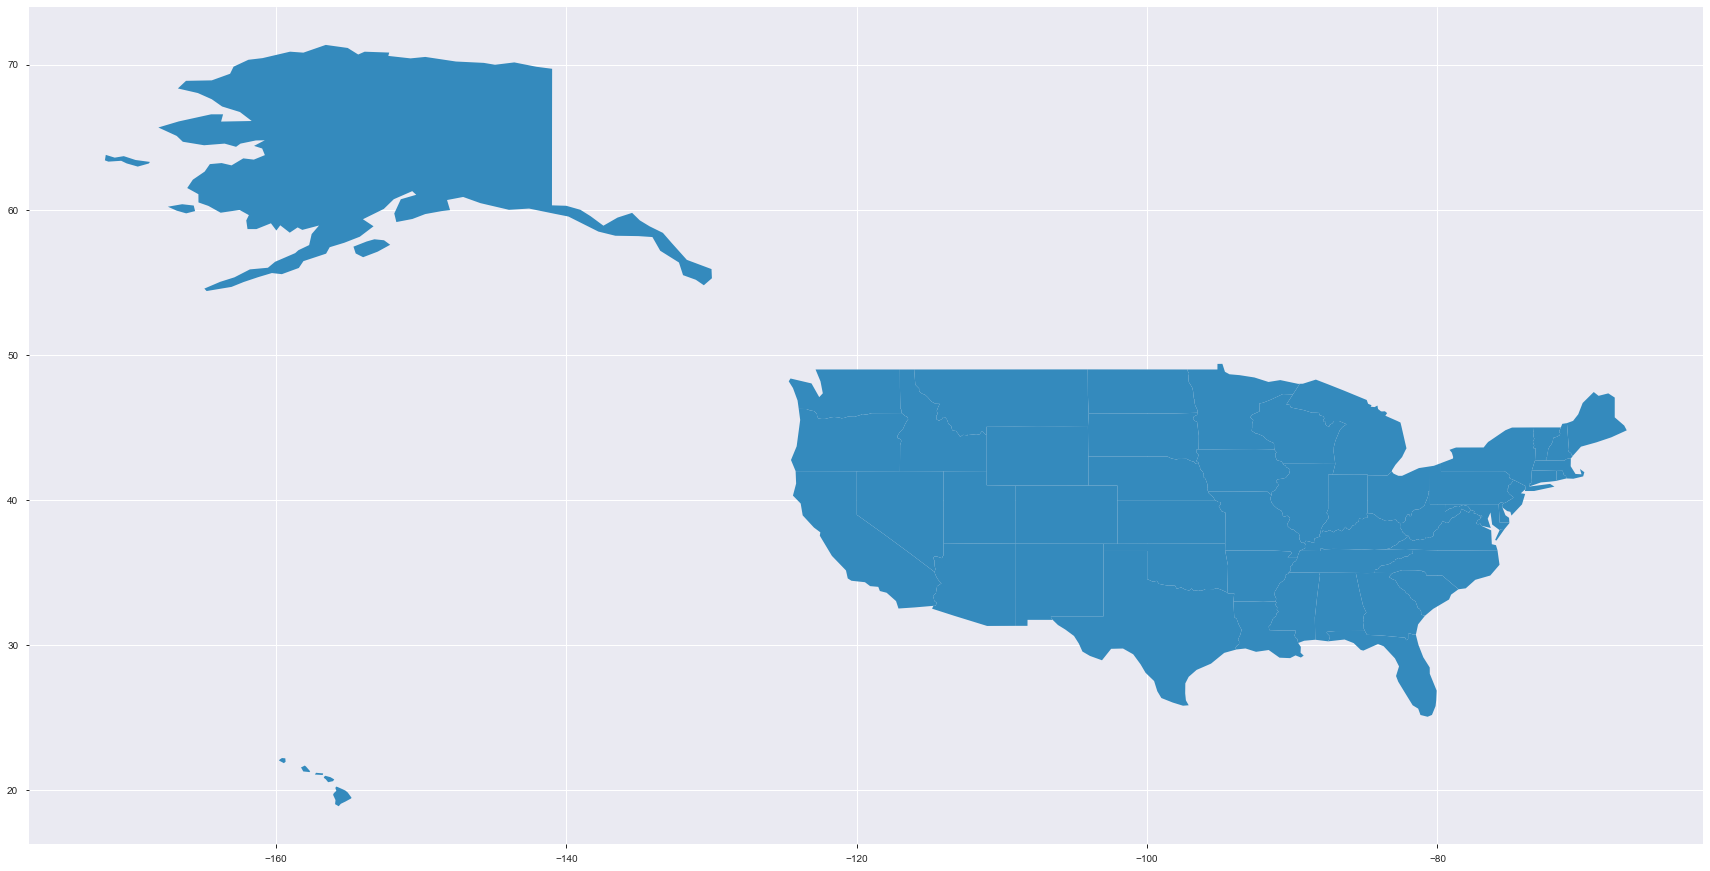

In [281]:
us_map.plot(figsize=(30, 20))

## Clean column names

# Data Cleaning: Clean wildfire data frame

# Request weather data from the Dark Sky API

## Pickle cleaned data frame

In [ ]:
# df.to_pickle('data/part2_cleaned_df.pickle')

In [ ]:
# df = pd.read_pickle('data/part2_cleaned_df.pickle')

## Create new column with all url parameters

In [ ]:
url_start = 'https://api.darksky.net/forecast/4f4ef1267ba7015a5e1b8aee6fb45ded/'
url_end = '?exclude=currently,minutely,hourly,flags.json'
df['WeatherDirectory'] = url_start + df['Latitude'].astype(
    str) + ',' + df['Longitude'].astype(str) + ',' + df['DateTime'].astype(str) + url_end

## Flatten json function

In [ ]:
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

## Import weather data and create weather data frame
The Dark Sky API requires the url to have the latitude, longitude, and timestamp.  
The code below makes a call for each start date of a wildfire (1 row per wildfire) and appends the weather data to a dataframe as a row.  
It also includes a 'unique_id' to use as a key in merging data frames.

In [ ]:
weather_df = pd.DataFrame()
new_unique_id = []

for index, row in df.iterrows():
    response = requests.get(row['WeatherDirectory']) # timeout=0.001
#     print(f'{link}', response.status_code) # 200 success
#     if response.status_code == 200:
    dark_sky_json = response.json()
    flat = flatten_json(dark_sky_json)
    weather_df = weather_df.append(flat, ignore_index=True)
    new_unique_id.append(row['UniqueId'])
#     weather_df['unique_id'] = batch_1['UniqueId']
weather_df['uniqueid'] = new_unique_id

## [Canceled ] Dark Sky Python API
I emailed the owner of this API and there was an error in the 'readme' file which is why the script below didn't work.  
I came up with an alternate solution as seen above.

In [ ]:
# # Canceled
# from darksky.api import DarkSky, DarkSkyAsync
# from darksky.types import languages, units, weather
# from datetime import datetime as dt

# API_KEY = '4f4ef1267ba7015a5e1b8aee6fb45ded'

# darksky = DarkSky(API_KEY)
# t = dt(2018, 5, 6, 12)

# latitude = 42.3601
# longitude = -71.0589
# forecast = darksky.get_forecast(
#     latitude, longitude,
#     extend=False, # default `False`
#     lang=languages.ENGLISH, # default `ENGLISH`
#     units=units.AUTO, # default `auto`
#     exclude=[weather.MINUTELY, weather.ALERTS], # default `[]`,
#     timezone='UTC' # default None - will be set by DarkSky API automatically
# )

# # Final wrapper identical for both ways
# forecast.latitude # 42.3601
# forecast.longitude # -71.0589
# forecast.timezone # timezone for coordinates. For exmaple: `America/New_York`

# forecast.currently # CurrentlyForecast. Can be found at darksky/forecast.py
# forecast.minutely # MinutelyForecast. Can be found at darksky/forecast.py
# forecast.hourly # HourlyForecast. Can be found at darksky/forecast.py
# forecast.daily # DailyForecast. Can be found at darksky/forecast.py
# forecast.alerts # [Alert]. Can be found at darksky/forecast.py

# Data Cleaning: Clean weather data frame

## Pickle our first weather data frame

In [ ]:
# weather_df.to_pickle('data/weather_first_df.pickle')

In [ ]:
# weather_df = pd.read_pickle('data/weather_first_df.pickle')

## Create CSV files
Create CSV to do some sanity checks

In [ ]:
# weather_df.to_csv(
#     '/Users/miguel/Git_Repos/sf20_ds17/corralm_projects/Project 2 – California Wildfires/weather_df_1.csv'
# )

## Remove unnecessary columns

Many of the features are essentially the same. We can remove these or feature engineer them.

In [ ]:
weather_df.info()

In [ ]:
columns_to_remove = [
    'daily_data_0_apparentTemperatureHigh',
    'daily_data_0_apparentTemperatureHighTime',
    'daily_data_0_apparentTemperatureLow',
    'daily_data_0_apparentTemperatureLowTime',
    'daily_data_0_apparentTemperatureMax',
    'daily_data_0_apparentTemperatureMaxTime',
    'daily_data_0_apparentTemperatureMin',
    'daily_data_0_apparentTemperatureMinTime', 
    'daily_data_0_cloudCover',
    'daily_data_0_icon', 
    'daily_data_0_ozone',
#     'daily_data_0_precipIntensity', # highly skewed with ~40% zeros
    'daily_data_0_precipIntensityMax',
    'daily_data_0_precipIntensityMaxTime',
    'daily_data_0_precipProbability',
    'daily_data_0_precipType',
    'daily_data_0_pressure', 
    'daily_data_0_summary',
    'daily_data_0_sunriseTime', # high correlation with 'daily_data_0_sunsetTime'
    'daily_data_0_temperatureHighTime', 
    'daily_data_0_temperatureLowTime',
    'daily_data_0_temperatureMax', 
    'daily_data_0_temperatureMaxTime',
    'daily_data_0_temperatureMin',
    'daily_data_0_temperatureMinTime', 
    'daily_data_0_time',
    'daily_data_0_uvIndex', # uvIndex has 1335 non-null values
    'daily_data_0_uvIndexTime', 
    'daily_data_0_visibility',
    'daily_data_0_windBearing', 
    'daily_data_0_windGust',
    'daily_data_0_windGustTime', 
    'offset', 
    'timezone',
    'daily_data_0_precipAccumulation'
#     'code',
#     'error' 
]
weather_df = weather_df.drop(columns_to_remove, axis=1)

In [ ]:
weather_df.info()

## Rename columns

In [ ]:
weather_df.columns = weather_df.columns.str.strip().str.lower().str.replace(
    'daily_data_0_', '').str.replace('(', '').str.replace(')', '')

## Drop the rows where at least one element is missing

In [ ]:
weather_df.shape

In [ ]:
weather_df = weather_df.dropna()
weather_df.shape

## Remove rows with erroneous 'longitude'

In [ ]:
# Get names of indexes for which longitude is greater than -114 (max eastern border of California)
index_names = weather_df[(weather_df['longitude'] > -114)].index
 
# Delete these row indexes from weather_df
weather_df.drop(index_names , inplace=True)

weather_df.shape

In [ ]:
profile = ProfileReport(weather_df, title='Weather Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

# Merge wildfire and weather data frames

## Pickle data frames before merging

In [ ]:
# weather_df.to_pickle('data/weather_pre_merge.pickle')
# df.to_pickle('data/pre_merge_df.pickle')

In [ ]:
weather_df = pd.read_pickle('data/weather_pre_merge.pickle')
df = pd.read_pickle('data/pre_merge_df.pickle')

## Rename 'unique_id' column for the join

In [ ]:
df = df.rename({'UniqueId': 'unique_id'}, axis='columns')
weather_df = weather_df.rename({'uniqueid': 'unique_id'}, axis='columns')

## Merge wildfire and weather data frames

In [ ]:
wildfire_df = pd.merge(df, weather_df, how='inner', on='unique_id', sort=True).reset_index()

In [ ]:
wildfire_df.shape

## Remove 'latitude' and 'longitude' columns as they are duplicated

In [ ]:
wildfire_df.drop(['Latitude','Longitude'],  axis='columns', inplace=True)

## Clean column names

In [ ]:
wildfire_df.columns = wildfire_df.columns.str.strip().str.lower().str.replace('(', '').str.replace(')', '')

## Convert 'started' & 'extinguished' to dates

In [ ]:
wildfire_df['started'] = pd.to_datetime(wildfire_df['started'].dt.date)
wildfire_df['extinguished'] = pd.to_datetime(wildfire_df['extinguished'].dt.date)

In [ ]:
wildfire_df.info()

In [ ]:
columns_to_remove = [
    'level_0',
    'index',
    'location',
    'datetime',
    'counties',
    'countyids',
    'weatherdirectory'
]
wildfire_df = wildfire_df.drop(columns_to_remove, axis=1)

## Create month column

In [ ]:
wildfire_df['month'] = pd.DatetimeIndex(wildfire_df['started']).month

## Remove erroneous rows

In [ ]:
index_names = wildfire_df[(wildfire_df['started'] < '2013-01-01')].index
 
# Delete these row indexes from weather_df
wildfire_df.drop(index_names , inplace=True)
wildfire_df.shape

## Remove rows with zero acres burned

In [ ]:
index_names = wildfire_df[(wildfire_df['acresburned'] <= 0)].index
 
# Delete these row indexes from weather_df
wildfire_df.drop(index_names , inplace=True)
wildfire_df.shape

## [Skip] Filter for Cal Fire Incidents
Data might be cleaner 

In [ ]:
# wildfire_df = wildfire_df[(wildfire_df['calfireincident'] == 'true')]
# wildfire_df.shape

## [Skip] Remove rows with duration > 52 days
https://mashable.com/article/wildfire-burn-how-long-climate-change/

In [ ]:
# index_names = wildfire_df[(wildfire_df['durationdays'] > 60) | (wildfire_df['durationdays'] <= 1)].index
 
# # Delete these row indexes from weather_df
# wildfire_df.drop(index_names , inplace=True)
# wildfire_df.shape

# Final Exploratory Data Analysis

## Pickle data frame

In [ ]:
# wildfire_df.to_pickle('data/wildfire_pre_eda.pickle')

In [ ]:
# wildfire_df = pd.read_pickle('data/wildfire_pre_eda.pickle')

## Profile report for 'wildfire_df'

In [ ]:
profile = ProfileReport(wildfire_df, title='Wildfire Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

# [Canceled Items]

## [Canceled] Parse Data with Selenium & BeautifulSoup

In [ ]:
# import os
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import time

# chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
# os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
# url = 'https://www.fire.ca.gov/incidents/2019/' 

# driver = webdriver.Chrome(chromedriver)
# driver.get(url)
# time.sleep(3)

In [ ]:
# element = driver.find_element_by_tag_name('body')

In [ ]:
# for _ in range(5):
#     element.send_keys(Keys.SPACE)

In [ ]:
# html = driver.execute_script("return document.body.innerHTML")

In [ ]:
# soup = BeautifulSoup(html, 'html.parser')

In [ ]:
# stuff = soup.find_all('div', {'class':'responsive-table-row'})

In [ ]:
# [entry.text.strip() for entry in stuff]

In [ ]:
# for row in stuff:
#     row = row.text.strip()
#     print(row)    

In [ ]:
# driver.quit()